# Step 1: 1st Round Results Analysis

## Objective

In this step we analyze the results for the first round of requests.

We check model performance and also compare the new data with the old data and we analyze if there is evidence of data drift with a EDA and the Kolmogorov–Smirnov test.

## Findings

During the first round of requests we successfully received and provided predictions for 4000 requests. We expected a recall of 0.821, but we observed a recall of 0.73 during the first round. Out of the 4000 requests, the model suggested a search for 2579, which means a reduction of 35.5%. According to the true outcome of the operations, the success rate of search operations was 22%, whereas when considering searches suggested by the model the success rate would have been 25%. In regards to discrimination, we expected an average success rate difference between race-gender pairs for all stations of 0.09. During the first round of requests, we actually got an average difference of 0.15, which was worse than expected.

In regards to data drift, according to the Kolmogorov–Smirnov considering a p-value of 0.005, we observed that the only features that don’t show data drift are Gender and Object of search.

In [110]:
import aux_functions
from app_functions import attempt_predict
from transformers import TimeTransformer2, BoolTransformer, lat_lon_imputer, Group_Age_Range, Group_Ethnicity

import json
import joblib
import pickle
import requests
from time import sleep
import random

import pandas as pd
pd.set_option('display.max_columns', 100)
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
import seaborn as sns
import numpy as np
import datetime as dt

from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score
# from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, RobustScaler, OrdinalEncoder
from category_encoders.target_encoder import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.utils import resample
from sklearn.metrics import precision_score, recall_score, f1_score,  accuracy_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve

# needed to use matplotlib inside jupyter notebook
%matplotlib inline 

In [111]:
def show_unique_value_graph(df, column):
    # This functions is used to plot a bar graph with the number of unique values for a specific feature
    # If the number of unique values is higher than 10 it displays value counts instead

    print("The list of unique values in '" + column + "' is :" + str(list(df[column].unique())))

    if(len(df[column].unique()) < 10):
        df[column].value_counts(dropna=False).plot.barh()
        plt.title("Distinct values count for " + column);
    else:
        display(df[column].value_counts(dropna=False))

# Get the Data

In [112]:
df_ = pd.read_csv("data/requests1_final.csv").drop(columns=["Unnamed: 0", "id"])

df_.head()

,observation_id,type,date,part_of_a_policing_operation,latitude,longitude,gender,age_range,officer_defined_ethnicity,legislation,object_of_search,station,proba,outcome,true_outcome
0,1b553034-0b2b-435b-b614-ce0a6c8d5f83,Person search,2022-01-01T01:05:06+00:00,False,52.574810,-0.241137,Male,10-17,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,cambridgeshire,0.467584,False,True
1,36ec1461-5190-496c-b82f-95c7ae9ff59f,Person search,2022-01-01T01:14:23+00:00,False,51.506256,-0.074901,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.123517,False,False
2,6f38f480-c0a0-45fb-81cd-ab56f0bb6351,Person search,2022-01-01T01:20:32+00:00,False,51.506256,-0.074901,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.123517,False,False
3,e7ab1073-5193-4ec6-aa07-efb0bc97acbb,Person search,2022-01-01T01:28:56+00:00,False,51.506256,-0.074901,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.123517,False,False
4,ec925f54-c0dd-4527-b941-fcb87a12ec1c,Person search,2022-01-01T02:16:00+00:00,False,50.712350,-3.553934,Male,over 34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,devon-and-cornwall,0.120817,False,False


# First Round of Requests EDA

## Data Description

In [113]:
print("The dataset has " + str(len(df_)) + " records.")
print("The dataset has " + str(len(df_.columns)) + " features.")
print("The dataset has " + str(df_["observation_id"].nunique()) + " unique observation_ids.")

The dataset has 4000 records.
The dataset has 15 features.
The dataset has 4000 unique observation_ids.


In [114]:
df_.dtypes

observation_id                   object
type                             object
date                             object
part_of_a_policing_operation       bool
latitude                        float64
longitude                       float64
gender                           object
age_range                        object
officer_defined_ethnicity        object
legislation                      object
object_of_search                 object
station                          object
proba                           float64
outcome                            bool
true_outcome                       bool
dtype: object

## Lat and Lon Feature Analysis

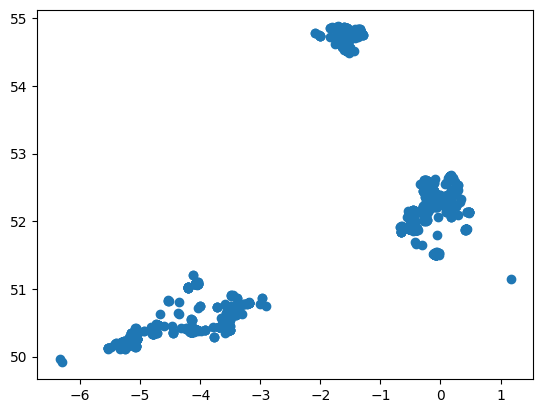

In [115]:
plt.scatter(x=df_["longitude"],y=df_["latitude"])

# coordinates are in WGS - 84

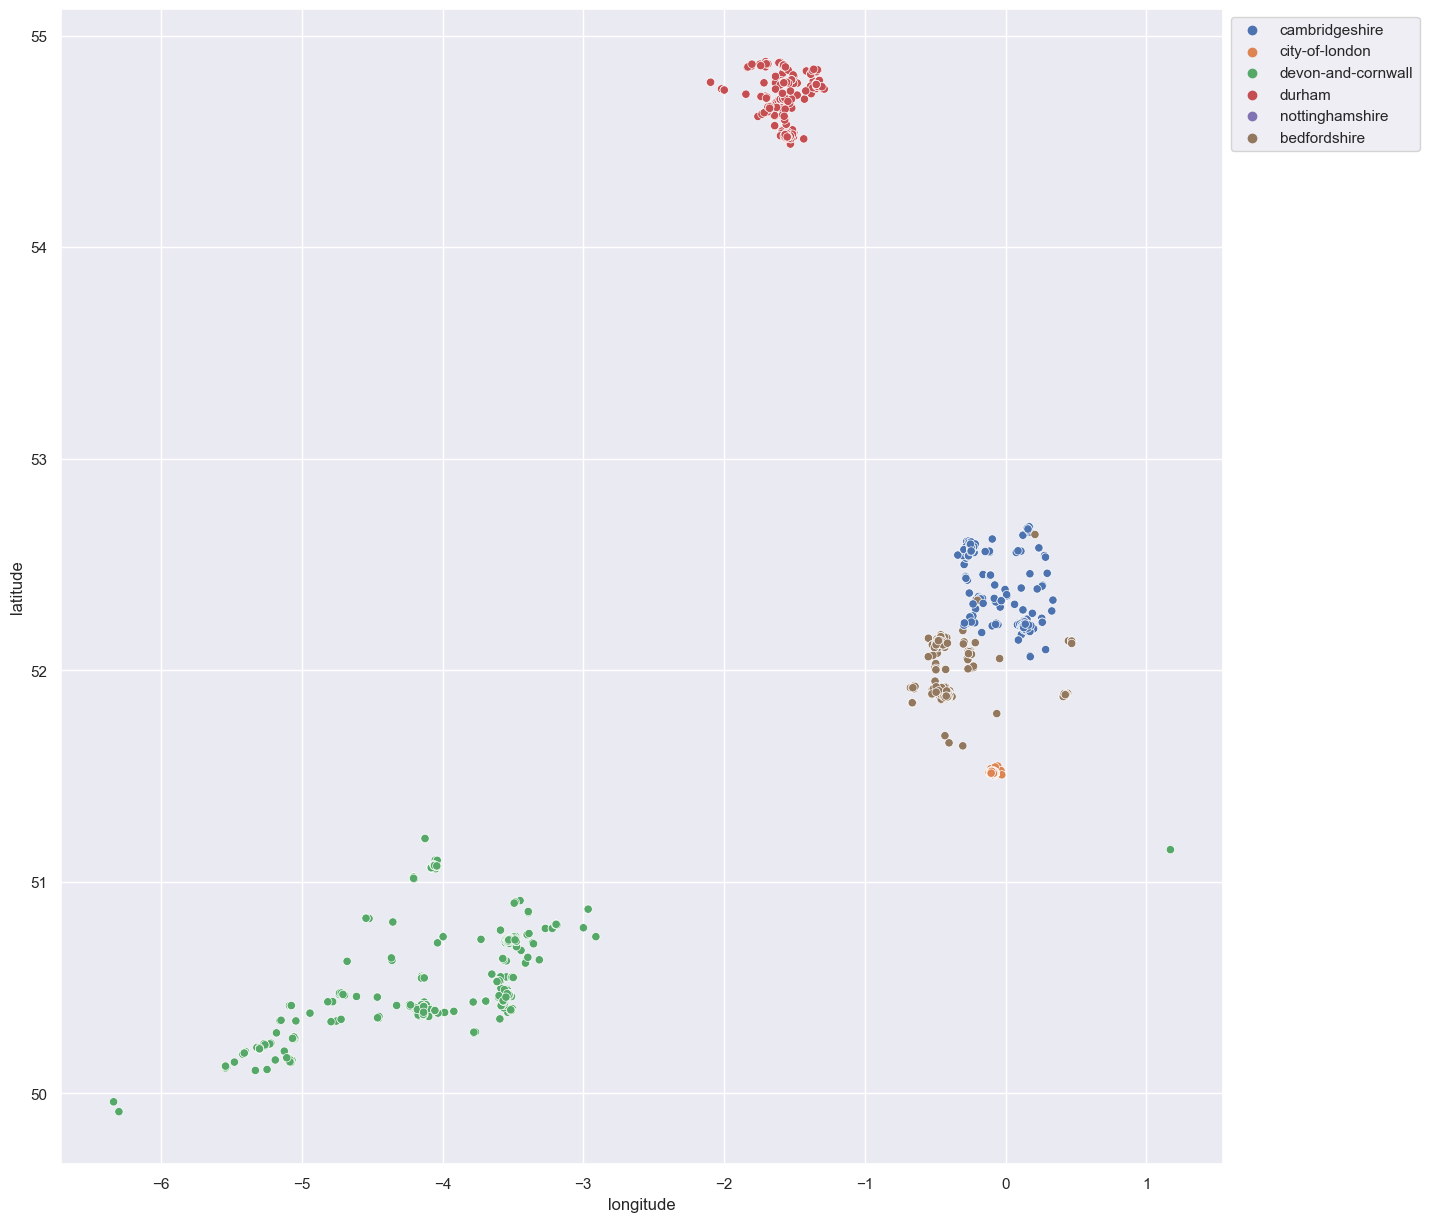

In [116]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(data= df_, x="longitude",y="latitude", hue="station")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [117]:
plt.style.use('default')

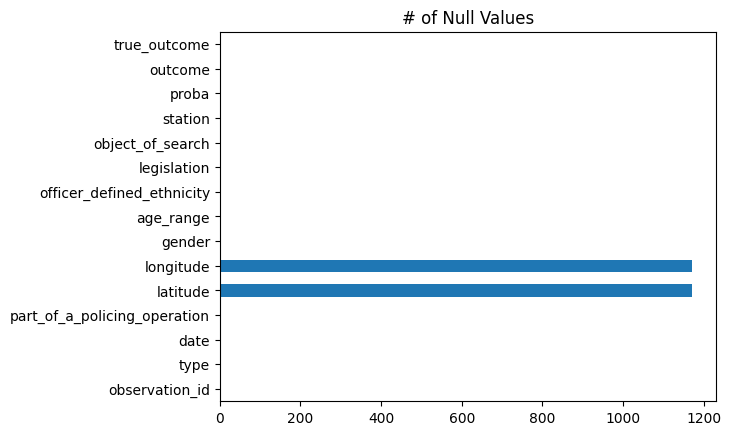

In [118]:
df_.isna().sum().plot.barh()
plt.title("# of Null Values");

The list of unique values in 'type' is :['Person search', 'Person and Vehicle search']


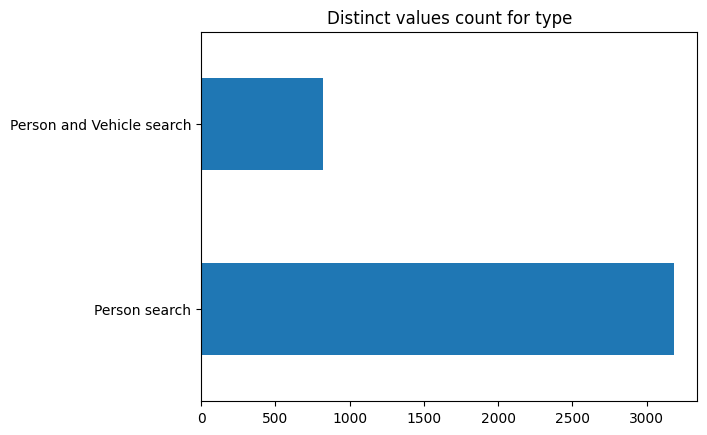

In [119]:
show_unique_value_graph(df_, "type")

The list of unique values in 'part_of_a_policing_operation' is :[False, True]


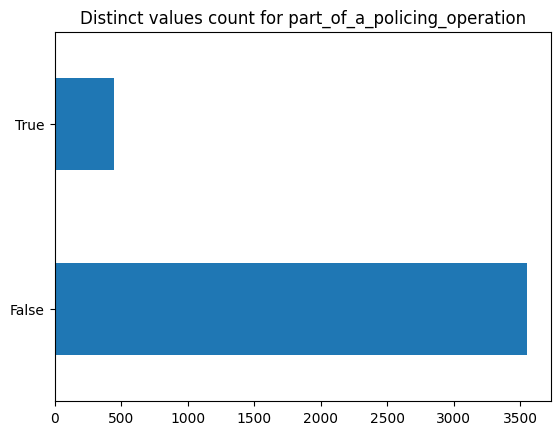

In [120]:
show_unique_value_graph(df_, "part_of_a_policing_operation")

The list of unique values in 'gender' is :['Male', 'Female', 'Other']


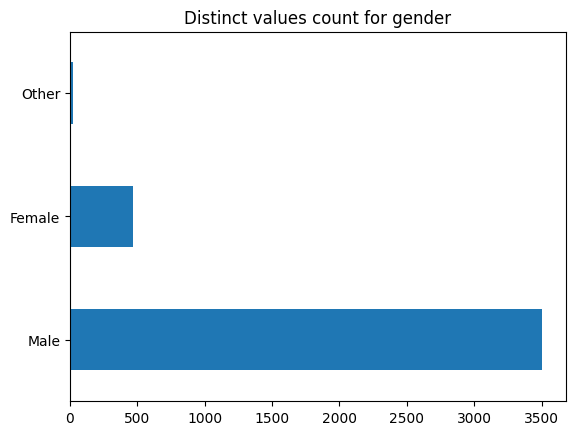

In [121]:
show_unique_value_graph(df_, "gender")

The list of unique values in 'age_range' is :['10-17', 'over 34', '18-24', '25-34', 'under 10']


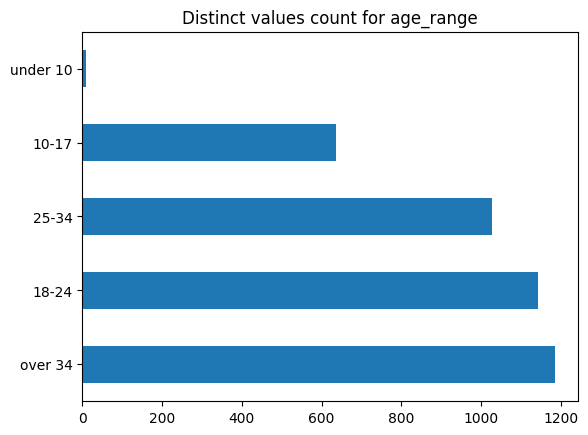

In [122]:
show_unique_value_graph(df_, "age_range")

The list of unique values in 'officer_defined_ethnicity' is :['Asian', 'White', 'Other', 'Black', 'Mixed']


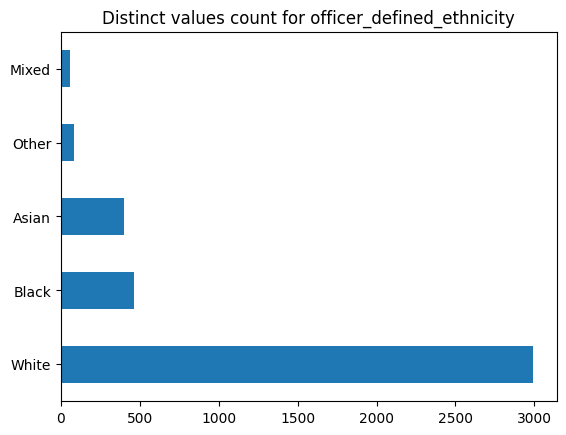

In [123]:
show_unique_value_graph(df_, "officer_defined_ethnicity")

### Race-Gender-Age Tuple Analysis

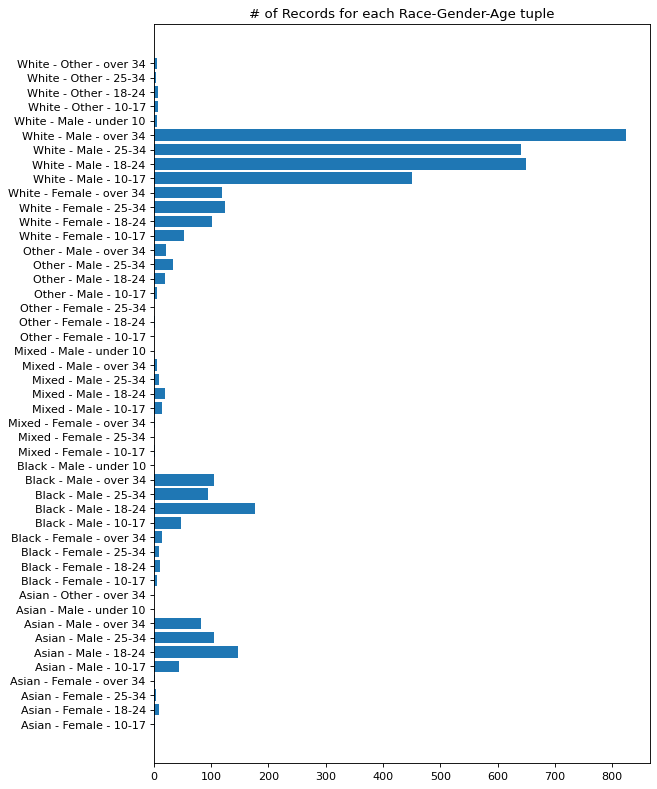

In [124]:
df_sensitive_classes = df_.copy()

df_sensitive_classes["sensitive_class"] = (df_sensitive_classes["officer_defined_ethnicity"] + " - "
                                           + df_sensitive_classes["gender"] + " - "
                                           + df_sensitive_classes["age_range"])

sensitive_class_dist = df_sensitive_classes["sensitive_class"].value_counts(dropna=False).sort_index()

plt.figure(figsize=(8, 12), dpi=80)

plt.barh(sensitive_class_dist.index, sensitive_class_dist)
plt.title("# of Records for each Race-Gender-Age tuple");

The list of unique values in 'legislation' is :['Misuse of Drugs Act 1971 (section 23)', 'Police and Criminal Evidence Act 1984 (section 1)', 'Criminal Justice and Public Order Act 1994 (section 60)', 'Criminal Justice Act 1988 (section 139B)', 'Firearms Act 1968 (section 47)', 'Psychoactive Substances Act 2016 (s36(2))', 'Poaching Prevention Act 1862 (section 2)']


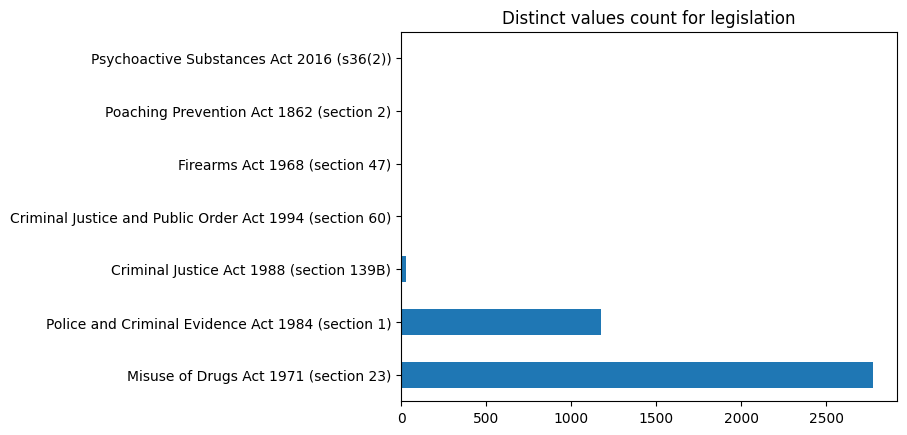

In [125]:
show_unique_value_graph(df_, "legislation")

In [126]:
show_unique_value_graph(df_, "object_of_search")

The list of unique values in 'object_of_search' is :['Controlled drugs', 'Offensive weapons', 'Article for use in theft', 'Stolen goods', 'Firearms', 'Articles for use in criminal damage', 'Fireworks', 'Psychoactive substances', 'Game or poaching equipment', 'Evidence of offences under the Act']


Controlled drugs                       2783
Offensive weapons                       500
Article for use in theft                400
Stolen goods                            262
Articles for use in criminal damage      26
Firearms                                 10
Fireworks                                 8
Game or poaching equipment                5
Evidence of offences under the Act        5
Psychoactive substances                   1
Name: object_of_search, dtype: int64

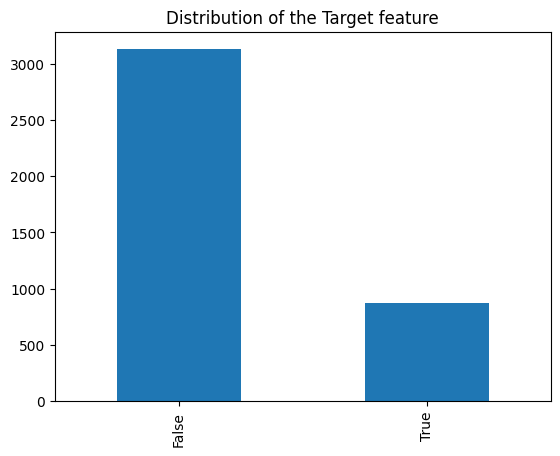

In [127]:
df_['true_outcome'].value_counts(dropna=False).plot.bar()
plt.title("Distribution of the Target feature")
plt.show();

The list of unique values in 'outcome' is :[False, True]


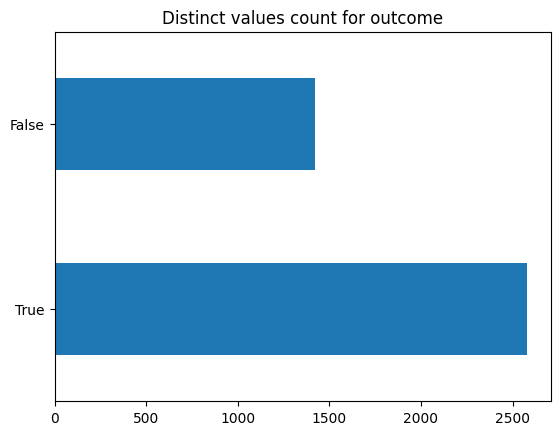

In [128]:
show_unique_value_graph(df_, "outcome")

## Encode Categorical Features

In [129]:
# dropping observation_id seen as it doesn't add any relevant information

df_cat = df_.copy().drop(columns='observation_id')

# converting date column

df_cat["date"] = pd.to_datetime(df_cat["date"], infer_datetime_format=True, dayfirst=False)

# categorical column

cat_columns = ['type', 'gender', 'officer_defined_ethnicity', 'legislation',
       'object_of_search', 'outcome', 'station']

for col in cat_columns:
    df_cat[col] = df_cat[col].astype('category').cat.as_unordered()

# ordered column

df_cat['age_range'] = df_cat['age_range'].astype('category').cat.as_ordered().cat.reorder_categories(['under 10', '10-17', '18-24', '25-34', 'over 34'], ordered=True)

df_cat['age_range']

# boolean columns

bool_columns = ['part_of_a_policing_operation']

for col in bool_columns:
    df_cat[col] = df_cat[col].astype('boolean')

df_cat.dtypes

type                                       category
date                            datetime64[ns, UTC]
part_of_a_policing_operation                boolean
latitude                                    float64
longitude                                   float64
gender                                     category
age_range                                  category
officer_defined_ethnicity                  category
legislation                                category
object_of_search                           category
station                                    category
proba                                       float64
outcome                                    category
true_outcome                                   bool
dtype: object

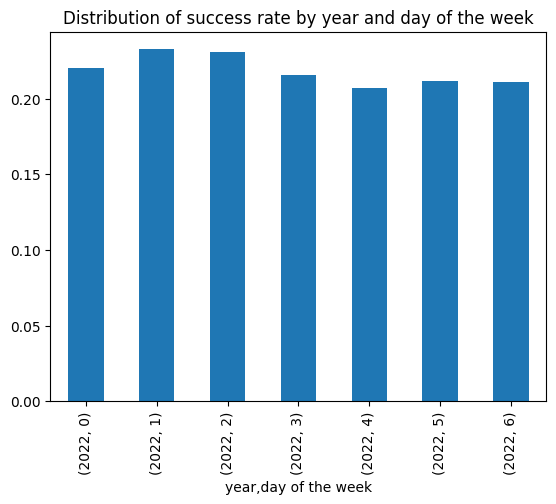

In [130]:
date_check = df_cat.copy()
date_check['quarter'] = date_check['date'].dt.quarter
date_check['year'] = date_check['date'].dt.year
date_check['hour'] = date_check['date'].dt.hour
date_check['day of the week'] = date_check['date'].dt.weekday
date_group = date_check.groupby(['year','day of the week'])["true_outcome"].agg(['size', np.sum])
date_group['rate'] = date_group['sum'] / date_group['size']
date_group["rate"].plot.bar()
plt.title("Distribution of success rate by year and day of the week")
plt.show();

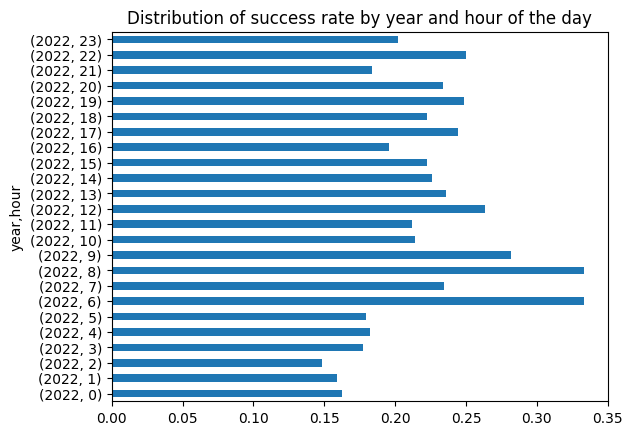

In [131]:
date_check = df_cat.copy()
date_check['quarter'] = date_check['date'].dt.quarter
date_check['year'] = date_check['date'].dt.year
date_check['hour'] = date_check['date'].dt.hour
date_check['day of the week'] = date_check['date'].dt.weekday
date_group = date_check.groupby(['year','hour'])["true_outcome"].agg(['size', np.sum])
date_group['rate'] = date_group['sum'] / date_group['size']
date_group["rate"].plot.barh()
plt.title("Distribution of success rate by year and hour of the day")
plt.show();

# Analyze Model Results

In [132]:
recall_score(df_cat["true_outcome"].astype(int), df_cat["outcome"].astype(int))

0.7299771167048055

In [133]:
df_cat

,type,date,part_of_a_policing_operation,latitude,longitude,gender,age_range,officer_defined_ethnicity,legislation,object_of_search,station,proba,outcome,true_outcome
0,Person search,2022-01-01 01:05:06+00:00,False,52.574810,-0.241137,Male,10-17,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,cambridgeshire,0.467584,False,True
1,Person search,2022-01-01 01:14:23+00:00,False,51.506256,-0.074901,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.123517,False,False
2,Person search,2022-01-01 01:20:32+00:00,False,51.506256,-0.074901,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.123517,False,False
3,Person search,2022-01-01 01:28:56+00:00,False,51.506256,-0.074901,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,city-of-london,0.123517,False,False
4,Person search,2022-01-01 02:16:00+00:00,False,50.712350,-3.553934,Male,over 34,White,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,devon-and-cornwall,0.120817,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,Person search,2022-03-11 16:16:00+00:00,True,NaN,NaN,Male,10-17,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,nottinghamshire,0.851334,True,True
3996,Person search,2022-03-11 23:11:00+00:00,False,NaN,NaN,Male,10-17,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,bedfordshire,0.546043,True,False
3997,Person and Vehicle search,2022-03-12 09:44:19+00:00,False,51.521810,-0.097929,Male,18-24,Asian,Misuse of Drugs Act 1971 (section 23),Controlled drugs,city-of-london,0.644289,True,True
3998,Person search,2022-03-13 12:14:31+00:00,False,51.513298,-0.101959,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,city-of-london,0.559123,True,True


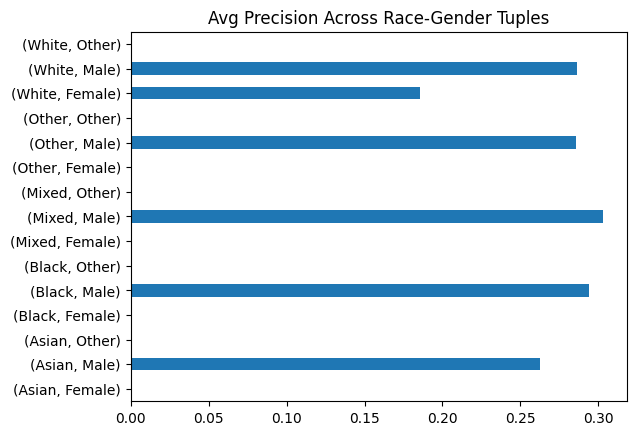

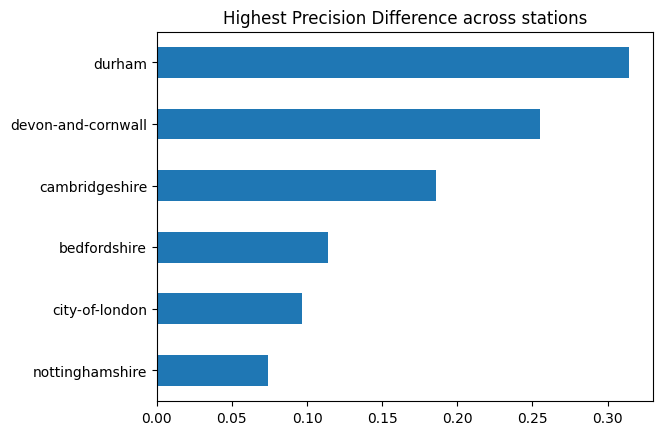

Discrimination requirement
Requirement failed
Global rates: {('Asian', 'Male'): 0.26286424409275677, ('Asian', 'Female'): nan, ('Asian', 'Other'): nan, ('White', 'Male'): 0.28613488161180817, ('White', 'Female'): 0.18568219043063589, ('White', 'Other'): nan, ('Other', 'Male'): 0.2857142857142857, ('Other', 'Female'): nan, ('Other', 'Other'): nan, ('Black', 'Male'): 0.29397704405942393, ('Black', 'Female'): nan, ('Black', 'Other'): nan, ('Mixed', 'Male'): 0.30303030303030304, ('Mixed', 'Female'): nan, ('Mixed', 'Other'): nan}
Num problematic departments: 6
Num good departments: 0
avg diff: 0.17329333333333338


In [134]:
column_mapper = {'type': 'Type', 
                    'date': 'Date',
                    'part_of_a_policing_operation': 'Part of a policing operation', 
                    'latitude': 'Latitude', 
                    'longitude': 'Longitude', 
                    'gender': "Gender",
                    'age_range': 'Age range', 
                    'officer_defined_ethnicity': 'Officer-defined ethnicity', 
                    'legislation': 'Legislation',
                    'object_of_search': 'Object of search',
                    'true_outcome': "target"
                    }

df_renamed = df_cat.rename(columns=column_mapper)




is_satisfied, problematic_departments, good_deparments, global_precisions, all_departments = aux_functions.verify_no_discrimination_v3(df_renamed, df_renamed["target"].astype(int), df_renamed["outcome"].astype(int))

print("Discrimination requirement")
if not is_satisfied:
    print("Requirement failed")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))
    print("avg diff:", all_departments["diff"].mean())
else:
    print("Requirement satisfied!")

In [135]:
# Check client success rate req

pred_outcome = df_cat["outcome"].astype(int)

real_outcome = df_cat["true_outcome"].astype(int)

aux_functions.verify_success_rate(real_outcome, pred_outcome, min_success_rate=0.1)

(True, 0.7299771167048055)

In [136]:
df_result = df_cat.copy()

total = len(df_result)

model_predictions = len(df_result[df_result["outcome"] == 1])

difference = total - model_predictions

print("The 1st round of requests data had " + str(total) + " searches")

print("With the new model we would have performed " + str(model_predictions) + " searches which is " + str(difference) + " less than the original, or a reduction of " +  str(round((difference / total) * 100, 2)) + " %")

The 1st round of requests data had 4000 searches
With the new model we would have performed 2579 searches which is 1421 less than the original, or a reduction of 35.52 %


In [137]:
original_success = (len(df_result[df_result["true_outcome"] == 1]) / len(df_result))

model_success = (len(df_result[(df_result["true_outcome"] == 1) & (df_result["outcome"] == 1)]) / len(df_result[(df_result["outcome"] == 1)]))

print("In the original data, the success rate of search operations was " + str(round(original_success,2))) 

print("With the model, the success rate of search operations would be " + str(round(model_success,2)))

In the original data, the success rate of search operations was 0.22
With the model, the success rate of search operations would be 0.25


In [138]:
missed_cases = len(df_result[(df_result["true_outcome"] == 1) & (df_result["outcome"] == 0)])

missed_ratio = missed_cases / len(df_result[(df_result["true_outcome"] == 1)])

print("With the model we would have missed " + str(missed_cases) + " cases which corresponds to " + str(round(missed_ratio * 100, 2)) + " % of all successes in the original data")

With the model we would have missed 236 cases which corresponds to 27.0 % of all successes in the original data


# Discrimination for True Outcome

In [139]:

    
departments = df_result['station'].unique()
ethnicity_classes = df_result['officer_defined_ethnicity'].unique()
gender_classes = df_result['gender'].unique()

sensitive_classes = [(x,y) for x in ethnicity_classes for y in gender_classes]

department_rates = {}
for department in departments:
    true_rates = {}
    for sensitive_class in sensitive_classes:

        mask = (df_result['officer_defined_ethnicity'] == sensitive_class[0]) & (df_result['gender'] == sensitive_class[1]) & (df_result['station'] == department)
        
        total = len(df_result[mask])
        target_true = len(df_result[mask  & (df_result['true_outcome'] == 1)])
        target_false = len(df_result[mask  & (df_result['true_outcome'] == 0)])

        # client suggests checking discrimination only for race-gender tuples that have a minimum of 30 samples
        if(total < 30):
            true_rate = np.nan 
        else:
            true_rate = target_true / total

        true_rates[sensitive_class] = true_rate
    department_rates[department] = true_rates

rates = pd.DataFrame.from_dict(department_rates).transpose()
rates["diff"] = rates.max(axis=1).round(5) - rates.min(axis=1).round(5)
rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)
rates

/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_18206/2886594725.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_18206/2886594725.py:30: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)


Asian                  White                 Other  \
                        Male Female Other      Male    Female Other  Male   
cambridgeshire      0.260870    NaN   NaN  0.282230  0.234043   NaN   NaN   
city-of-london      0.218391    NaN   NaN  0.246154       NaN   NaN  0.25   
devon-and-cornwall       NaN    NaN   NaN  0.177549  0.157895   NaN   NaN   
durham                   NaN    NaN   NaN  0.284024  0.133333   NaN   NaN   
nottinghamshire     0.300000    NaN   NaN  0.212254  0.236364   NaN   NaN   
bedfordshire        0.240741    NaN   NaN  0.226730  0.186667   NaN   NaN   

                                    Black              Mixed               \
                   Female Other      Male Female Other  Male Female Other   
cambridgeshire        NaN   NaN  0.300000    NaN   NaN   NaN    NaN   NaN   
city-of-london        NaN   NaN  0.184466    NaN   NaN   NaN    NaN   NaN   
devon-and-cornwall    NaN   NaN  0.333333    NaN   NaN   NaN    NaN   NaN   
durham                NaN   NaN       NaN    NaN   NaN   NaN    NaN   NaN   
nottinghamshire       NaN   NaN  0.266667    NaN   NaN  0.22    NaN   NaN   
bedfordshire          NaN   NaN  0.147887    NaN   NaN   NaN    NaN   NaN   

                       diff    worst tuple       best tuple  
                                                             
cambridgeshire      0.06596  (Black, Male)  (White, Female)  
city-of-london      0.06553  (Other, Male)    (Black, Male)  
devon-and-cornwall  0.17544  (Black, Male)  (White, Female)  
durham              0.15069  (White, Male)  (White, Female)  
nottinghamshire     0.08775  (Asian, Male)    (White, Male)  
bedfordshire        0.09285  (Asian, Male)    (Black, Male)

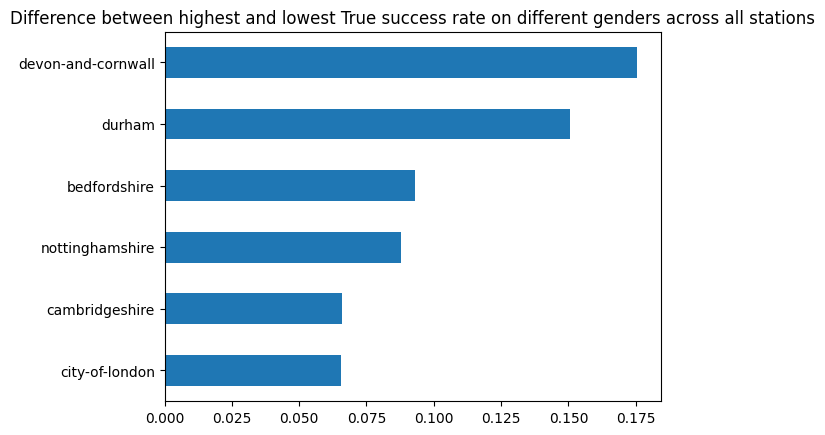

In [140]:
rates.sort_values(by="diff", ascending=True)["diff"].plot.barh()
plt.title("Difference between highest and lowest True success rate on different genders across all stations")
plt.show();

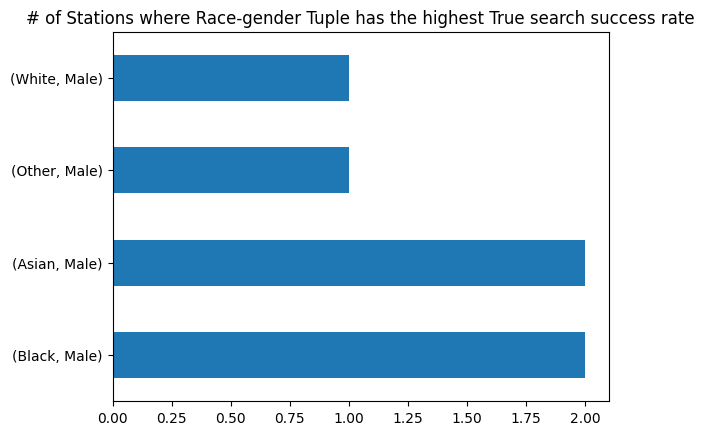

In [141]:
rates["worst tuple"].value_counts().plot.barh()
plt.title("# of Stations where Race-gender Tuple has the highest True search success rate")
plt.show();

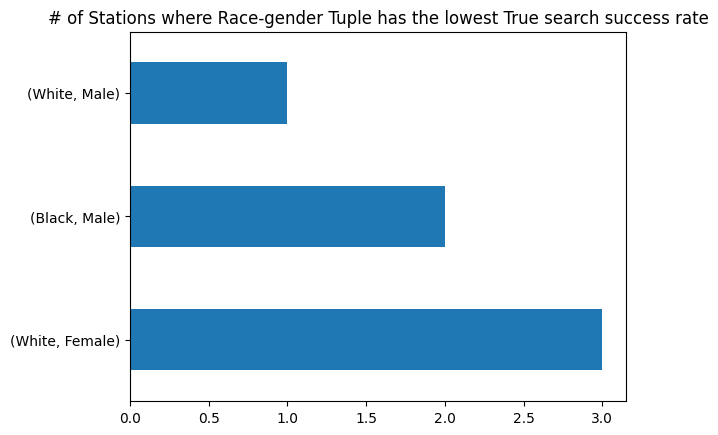

In [142]:
rates["best tuple"].value_counts().plot.barh()
plt.title("# of Stations where Race-gender Tuple has the lowest True search success rate")
plt.show();

# Discrimination for Predicted Outcome

In [143]:

    
departments = df_result['station'].unique()
ethnicity_classes = df_result['officer_defined_ethnicity'].unique()
gender_classes = df_result['gender'].unique()

sensitive_classes = [(x,y) for x in ethnicity_classes for y in gender_classes]

department_rates = {}
for department in departments:
    true_rates = {}
    for sensitive_class in sensitive_classes:

        mask = (df_result['officer_defined_ethnicity'] == sensitive_class[0]) & (df_result['gender'] == sensitive_class[1]) & (df_result['station'] == department)
        
        total = len(df_result[mask])
        target_true = len(df_result[mask  & (df_result['outcome'] == 1)])
        target_false = len(df_result[mask  & (df_result['outcome'] == 0)])

        # client suggests checking discrimination only for race-gender tuples that have a minimum of 30 samples
        if(total < 30):
            true_rate = np.nan 
        else:
            true_rate = target_true / total

        true_rates[sensitive_class] = true_rate
    department_rates[department] = true_rates

rates = pd.DataFrame.from_dict(department_rates).transpose()
rates["diff"] = rates.max(axis=1).round(5) - rates.min(axis=1).round(5)
rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)
rates

/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_18206/2936031415.py:29: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["worst tuple"] = rates.drop(columns=["diff"]).idxmax(axis=1)
/var/folders/sj/c0wtvkk15b92vcqw5rhy939r0000gn/T/ipykernel_18206/2936031415.py:30: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  rates["best tuple"] = rates.drop(columns=["diff", "worst tuple"]).idxmin(axis=1)


Asian                  White                     Other  \
                        Male Female Other      Male    Female Other      Male   
cambridgeshire      0.673913    NaN   NaN  0.571429  0.553191   NaN       NaN   
city-of-london      0.678161    NaN   NaN  0.615385       NaN   NaN  0.403846   
devon-and-cornwall       NaN    NaN   NaN  0.731959  0.763158   NaN       NaN   
durham                   NaN    NaN   NaN  0.207101  0.266667   NaN       NaN   
nottinghamshire     0.766667    NaN   NaN  0.708972  0.600000   NaN       NaN   
bedfordshire        0.790123    NaN   NaN  0.708831  0.813333   NaN       NaN   

                                    Black              Mixed               \
                   Female Other      Male Female Other  Male Female Other   
cambridgeshire        NaN   NaN  0.700000    NaN   NaN   NaN    NaN   NaN   
city-of-london        NaN   NaN  0.553398    NaN   NaN   NaN    NaN   NaN   
devon-and-cornwall    NaN   NaN  0.600000    NaN   NaN   NaN    NaN   NaN   
durham                NaN   NaN       NaN    NaN   NaN   NaN    NaN   NaN   
nottinghamshire       NaN   NaN  0.714286    NaN   NaN  0.66    NaN   NaN   
bedfordshire          NaN   NaN  0.809859    NaN   NaN   NaN    NaN   NaN   

                       diff      worst tuple       best tuple  
                                                               
cambridgeshire      0.14681    (Black, Male)  (White, Female)  
city-of-london      0.27431    (Asian, Male)    (Other, Male)  
devon-and-cornwall  0.16316  (White, Female)    (Black, Male)  
durham              0.05957  (White, Female)    (White, Male)  
nottinghamshire     0.16667    (Asian, Male)  (White, Female)  
bedfordshire        0.10450  (White, Female)    (White, Male)

In [144]:
rates.to_csv("results/discrimination_rates_1stround_predicted.csv")

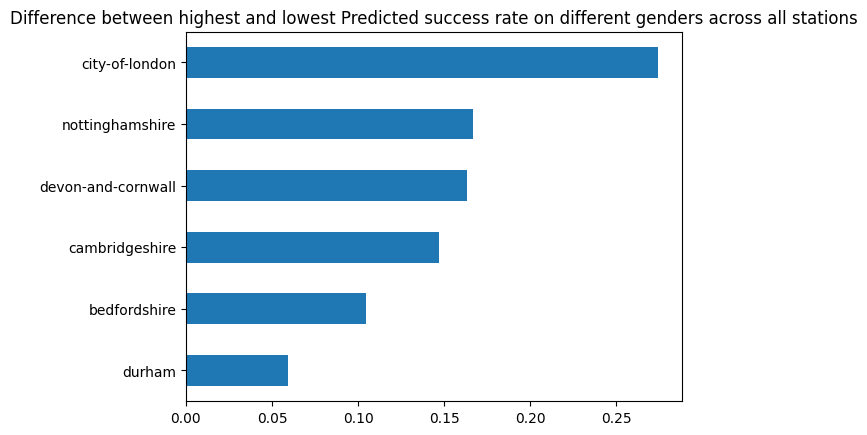

In [145]:
rates.sort_values(by="diff", ascending=True)["diff"].plot.barh()
plt.title("Difference between highest and lowest Predicted success rate on different genders across all stations")
plt.show();

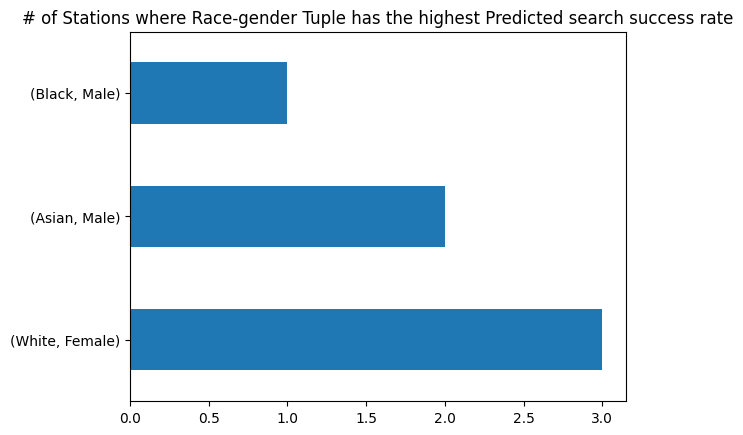

In [146]:
rates["worst tuple"].value_counts().plot.barh()
plt.title("# of Stations where Race-gender Tuple has the highest Predicted search success rate")
plt.show();

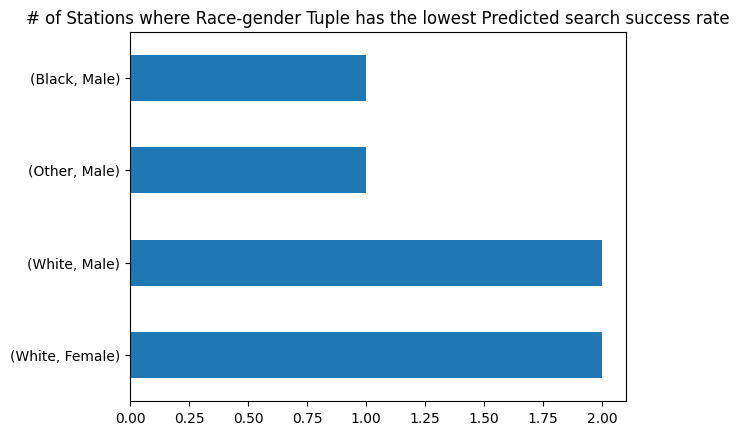

In [147]:
rates["best tuple"].value_counts().plot.barh()
plt.title("# of Stations where Race-gender Tuple has the lowest Predicted search success rate")
plt.show();

# Analyze Data Drift

In [148]:
df_original = pd.read_csv("data/train.csv")

# dropping stations with low values for Outcome linked to object of search

outcome_stations_to_drop = ['humberside', 'lancashire', 'metropolitan', 'west-midlands', 'leicestershire']

df_original = df_original.loc[~df_original["station"].isin(outcome_stations_to_drop),:].copy()

# converting Part of a policing operation to match datatype on df_new

df_original["Part of a policing operation"] = df_original["Part of a policing operation"].astype(bool)

# converting Legislation column to prevent error when calculating ks p-value

df_original["Legislation"] = df_original["Legislation"].astype(str)

# adding target feature

df_original['target'] = 0
df_original.loc[(df_original["Outcome"]!='A no further action disposal') & (df_original['Outcome linked to object of search']==True), 'target'] = 1

column_mapper = {'type': 'Type', 
                 'date': 'Date',
                 'part_of_a_policing_operation': 'Part of a policing operation', 
                 'latitude': 'Latitude', 
                 'longitude': 'Longitude', 
                 'gender': "Gender",
                 'age_range': 'Age range', 
                 'officer_defined_ethnicity': 'Officer-defined ethnicity', 
                 'legislation': 'Legislation',
                 'object_of_search': 'Object of search',
                 'true_outcome': "target"
                }

df_new = (pd.read_csv("data/requests1_final.csv").drop(columns=["Unnamed: 0", "id", "proba", "outcome"])
                                                 .rename(columns=column_mapper))

# converting target to match datatype on df_original

df_new["target"] = df_new["target"].astype(int)

# converting Legislation column to prevent error when calculating ks p-value

df_new["Legislation"] = df_new["Legislation"].astype(str)

## Target Comparison

<AxesSubplot:>

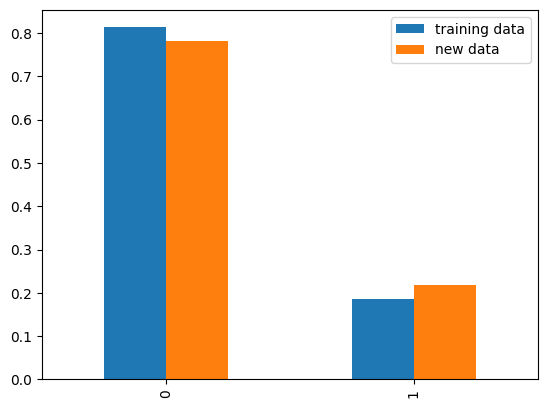

In [149]:

compare = {}

compare["training data"] = df_original["target"].value_counts(dropna=False, normalize=True).to_dict()

compare["new data"] = df_new["target"].value_counts(dropna=False, normalize=True).to_dict()

pd.DataFrame(compare).plot(kind="bar")

# Comparison of Success Rate across Race-Gender-Age tuples

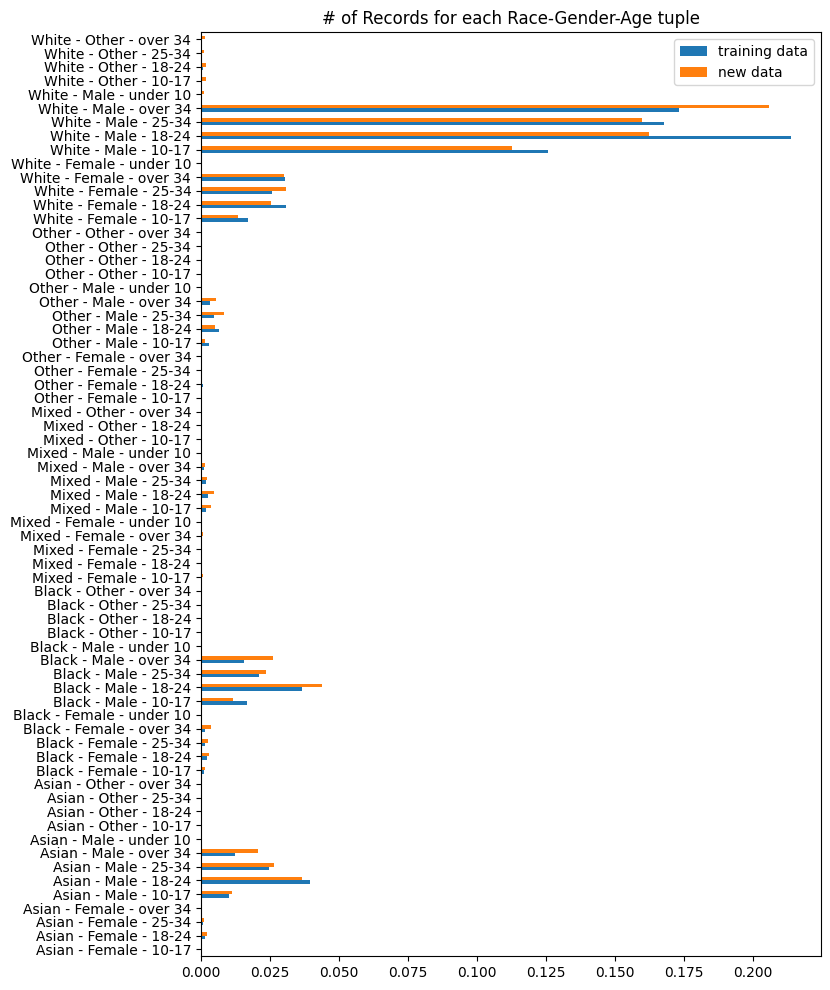

In [150]:
sensitive_class_dist = {}

df_aux = df_original.copy()

df_aux["sensitive_class"] = (df_aux["Officer-defined ethnicity"] + " - "
                                           + df_aux["Gender"] + " - "
                                           + df_aux["Age range"])

sensitive_class_dist["training data"] = df_aux["sensitive_class"].value_counts(dropna=False,normalize=True).to_dict()

df_aux = df_new.copy()

df_aux["sensitive_class"] = (df_aux["Officer-defined ethnicity"] + " - "
                                           + df_aux["Gender"] + " - "
                                           + df_aux["Age range"])

sensitive_class_dist["new data"] = df_aux["sensitive_class"].value_counts(dropna=False,normalize=True).to_dict()

df_sensitive_class = pd.DataFrame(sensitive_class_dist).sort_index()

# pd.DataFrame(sensitive_class_dist).sort_index().plot(kind="barh")

plt.rcParams["figure.figsize"] = (8,12)

pd.DataFrame(sensitive_class_dist).sort_index().plot(kind="barh")
plt.title("# of Records for each Race-Gender-Age tuple");



In [151]:
plt.style.use('default')

## Kolmogorov–Smirnov test

In [152]:
column_list = list(df_new.drop(columns=["observation_id", "target"]).columns)

ks_dict = {}
for column in column_list:

    pvalue = ks_2samp(df_original[column], df_new[column]).pvalue
    ks_dict[column] = pvalue



In [153]:
pd.DataFrame(ks_dict, index=["p-value"]).transpose()

,p-value
Type,1.666366e-05
Date,0.000000e+00
Part of a policing operation,0.000000e+00
Latitude,5.708191e-112
Longitude,3.838618e-113
Gender,9.999909e-01
Age range,4.368291e-16
Officer-defined ethnicity,1.828964e-05
Legislation,6.440463e-40
Object of search,1.685093e-02


In [ ]:
pd.DataFrame(ks_dict, index=["p-value"]).transpose().to_csv("results/ks_test.csv")